# Qiskit implementation (solution): entanglement propagation in random quantum circuits

Assumption: you have a brief introduction on qiskit in Aachen. Our goal here is to implement a random quantum circuit and study the entanglement evolution in a many-body system.

In [1]:
%%capture
!python3 -m venv ./qi
!source ./qi/bin/activate
!pip install 'qiskit[visualization]'

In [2]:
import qiskit as qi
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import itertools as it

## **Task 1**

1. Create a circuit that generate a random state on $N$ qubits.
2. Write a function to compute the reduced purity given a state $|\Psi\rangle$ over the subsystem $A$. 
3. Write function that given a subsystem $A$ of size $N_A$, and total size $N$, and $\mathcal{N}$ disorder realization, returns a list, or numpy array of $\mathcal{N}$ realizations of the reduced purity. 
4. Verify that the average purity of the reduced density matrix verify the formula
$$

\mathbb{E}\left(\mathrm{tr}(\rho_A^2)\right) = \frac{d_A + d_B}{d_A d_B+1}

$$
with dimension $d_A = 2^{N_A}$ and $d_B = 2^{N-N_A}$. Focus on $N=8$, $N_A\le 4$ and $100\le \mathcal{N}\le 1000$. 


### **Hints:**
Use the `qi.quantum_info` library tools. Objects that can be useful are 
1. `qi.quantum_info.Statevector`, with the method `.from_label`
2. `qi.quantum_info.random_unitary` function returning a `qi.quantum_info.Operator`
3. `qi.quantum_info.partial_trace` function, returning a `qi.quantum_info.DensityMatrix`
4. `qi.quantum_info.DensityMatrix` has a method `.purity`.

In [6]:
qi.quantum_info.partial_trace?

Signature: qi.quantum_info.partial_trace(state, qargs)
Docstring:
Return reduced density matrix by tracing out part of quantum state.

If all subsystems are traced over this returns the
:meth:`~qiskit.quantum_info.DensityMatrix.trace` of the
input state.

Args:
    state (Statevector or DensityMatrix): the input state.
    qargs (list): The subsystems to trace over.

Returns:
    DensityMatrix: The reduced density matrix.

Raises:
    QiskitError: if input state is invalid.
File:      ~/miniconda3/lib/python3.11/site-packages/qiskit/quantum_info/states/utils.py
Type:      function

In [11]:
# 1. 
def generate_random_state(N : int) -> qi.quantum_info.Statevector :
  psi = qi.quantum_info.Statevector.from_label('0'*N)
  u_rand = qi.quantum_info.random_unitary(2**N)
  qr = qi.QuantumRegister(N,'data')
  qc = qi.QuantumCircuit(qr)
  
  qc.append(u_rand,qr)

  return psi.evolve(qc)

# 2. 
def reduced_density_matrix_purity(Psi: qi.quantum_info.Statevector,
                          subsystem: list[int]) -> float:
  rho = qi.quantum_info.partial_trace(Psi,subsystem)
  return rho.purity()

# 3.
def random_reduced_purity(subsystem: list[int], 
                          N: int, Nshots: int) -> list[float]:
  res = [] 
  for _ in range(Nshots):
    psi = generate_random_state(N)
    pur = reduced_density_matrix_purity(psi,subsystem=subsystem)
    res.append(pur.real)
  ## TODO: Initialize result list.
  ## TODO: Loop over the disorder realizations.
  ## TODO: For each realization, initialize a random state, compute purity and append to the results.
  return res 

In [15]:
psitest = generate_random_state(4)
N = 8 
NA = N//2
exact_result = lambda NA, N: (2**NA + 2**(N-NA))/(2**N+1)
list_res = random_reduced_purity(list(range(NA)),N,1000)
print(np.mean(list_res),exact_result(NA,N))


0.12432957967468278 0.1245136186770428


## **Task 1+**
What happens for $\mathbb{E}\left(\mathrm{tr}(\rho_A^q)\right)$, with generic $q$? 
1. Obtain, using the replica method discussed, the leading order when $1\ll d_A\ll d$ and $1\ll d_A \sim \mathcal{O(d)}$, e.g., $d_A = d/2$. 
2. Compute the annealed average Renyi entropy
$$ 
S_n = \frac{1}{1-n}\log_2\left[\mathbb{E}\left(\mathrm{tr}(\rho_A^q)\right)\right]. 
$$
3. What happens when $q\to 1$? 

## **Task 1++**
Realistically, if you do many-body dynamics, you should write your own code. In that case, a good exercise is:
1. Initialize a quantum state as a `numpy.array`. 
2. Generate a random unitary acting on the full state. Hint: use `scipy.stats.unitary_group` at present, otherwise implement by hand what is in [this paper](https://arxiv.org/abs/math-ph/0609050v2). 
3. Reshape the state vector, for a contiguous interval $A$, to construct $R(|\Psi\rangle) = X$. From this compute the reduced density matrix $\rho_A = X X^\dagger$. 
4. Compute the purity. Compare the results with `qiskit` to know your implementation is good (testing).

## **Task 2**
Create a brickwall quantum circuit  (Fig. from [Brian Skinner's lecture notes](https://arxiv.org/pdf/2307.02986.pdf)). 

<img src=circuit.png alt = "" width=40% height=20%>

Each gate in the figure is a random unitary acting on two qubits. You should apply the gate to two (nearest-neighbors) target circuits. For simplicity, assume open boundary conditions. 
1. First, create a layer of two body nearest neighboring random gates. Each layer is composed of a gates acting on even bonds ($2i,2i+1$) or odd bonds ($2i+1,2i+2$), depending on the depth $0 \tau\le t$
2. Compute the reduced purity after one layer of the circuit. What is the average of this operation over many results? What did you expect?
3. Compute the reduced purity after each layers, after $t$ layers. For each circuit realization, this should result in a time-series. 
4. Define a function, that given $N$, $N_A$, $\mathcal{N}$ (as in Task 1) and $t$ the total depth, gives a matrix $\mathcal{N}\times (t+1)$ where each row is a realization of the circuit. (The $+1$ comes because we save also the value at $t=0$).
5. Compute the average over the rows, resulting in the average evolution $1\times t$. From this, compute the Renyi 2 entropy. How is the entanglement growing? Do the computation for $N\le 12$ and $N_A=N/2$. 
6. Compare with the prediction $S_2 \simeq v t$ with $v=-2\log_2(4/5)$. How good is this? When does it break down?

In [35]:
# 1. 
def generate_brickwall_layer(N : int, t: int) -> qi.QuantumCircuit :
  # u_rand = qi.quantum_info.random_unitary(2**N)
  qr = qi.QuantumRegister(N,'data')
  qc = qi.QuantumCircuit(qr)
  if (t%2==0):
    for i in range(0,N,2):
      u = qi.quantum_info.random_unitary(2**2)
      qc.append(u,[i,i+1])
  else: 
    for i in range(1,N-1,2):
      u = qi.quantum_info.random_unitary(2**2)
      qc.append(u,[i,i+1])
  #
    # for i in range(t%2,N-(t%2),2):
    #   u = qi.quantum_info.random_unitary(2**2)
    #   qc.append(u,[i,i+1])

  return qc 

# 2. 
def purity_evolution_realization(subsystem: list[int], 
                                 N: int, t_total: int) -> list[float]:
  psi = qi.quantum_info.Statevector.from_label('0'*N)
  res = [1]
  for t in range(t_total):
    qc = generate_brickwall_layer(N,t)
    psi = psi.evolve(qc)
    pur = reduced_density_matrix_purity(psi,subsystem=subsystem)
    res.append(pur.real)
    
  return res 

# 3.
def purity_evolution_average(subsystem: list[int], 
                        N: int, t_total: int, Nshots: int) -> np.array:
  tot_reals = []
  for _ in range(Nshots):
    tot_reals.append(purity_evolution_realization(subsystem,N,t_total))
  tot_reals = np.array(tot_reals)
  return np.mean(tot_reals,axis=0)

exact_s_2 = lambda t : np.log(5/4)*t 

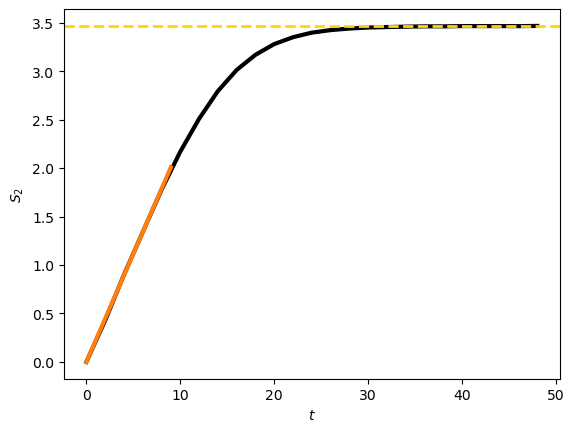

In [40]:
N = 12
NA = N//2
subsysA = list(range(NA))
# for _ in range(4):
#   purity = purity_evolution_realization(subsysA,N,4*N)
#   plt.plot(-np.log(purity))
tmax = 4*N
trange= np.arange(tmax+1)
average_purity = purity_evolution_average(subsysA,N,tmax,100)
plt.plot(trange[::2],-np.log(average_purity)[::2],c='black',lw=3)
plt.axhline(np.log(2)*(NA-1),c='gold',ls='--',lw=2)
plt.xlabel(r'$t$')
plt.ylabel(r'$S_2$')
plt.plot(trange[:10],exact_s_2(trange)[:10],c='C1',lw=3)


## **Task 3 (probably homework)**
What happens if now we add measurements? Let us implement measurement circuits.
1. Check for a 2-qubit random gate, what happens when I measure one of the qubit to the subsystem purity? What does this means for entanglement?
2. Write a circuit where after each unitary layer, a layer of random on-site measurements (of $Z_i$) is applied. Each site is measured with a probability $p$. 
3. Repeat the realization analysis for $N=8,12$ and $\mathcal{N}=100$, varying $p$ from $0$ to $1$. The case $p=0$ should reproduce the previous results (no measurements happen). At $p=1$ what is the final state? Is it entangled? What happens in between?